In [6]:
# to use GPU, first check on the terminal: 
# nvcc --version 
# nvidia-smi
# then turn use GPU to True

import tifffile as tiff
import matplotlib.pyplot as plt
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

>>> GPU activated? NO


In [8]:
# Custom model path
model_path = "/Volumes/projects-03/Feyza/segmentation/cellpose_nuclei_membrane/training_data_05z/models/CP_20241007_h2bxncad"

# Path to images
image_dir = "/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test"

# Channel Parameters
'''# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1
    
if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0'''

chan = 1
chan2 = 2

# Segmentation Parameters
diameter = 25
flow_threshold = 0.8
cellprob_threshold = -1


In [9]:
dir = "/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test"
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=False, 
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images, 
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )


['/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test/pos3_z121_t22-44-1.tif', '/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test/pos3_z121_t22-44-2.tif', '/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test/pos3_z121_t22-44-3.tif', '/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test/pos3_z121_t22-44-4.tif', '/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test/pos3_z121_t22-44-5.tif', '/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test/pos3_z121_t22-44-6.tif', '/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test/pos3_z121_t22-44-7.tif'

In [10]:
# save output to *_seg.npy
io.masks_flows_to_seg(images, 
                      masks, 
                      flows, 
                      files, 
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)), 
                      )

In [11]:
#save output masks to tiffs/pngs or txt files for imageJ
io.save_masks(images, 
              masks, 
              flows, 
              files, 
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs 
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )

(-0.5, 3599.5, 899.5, -0.5)

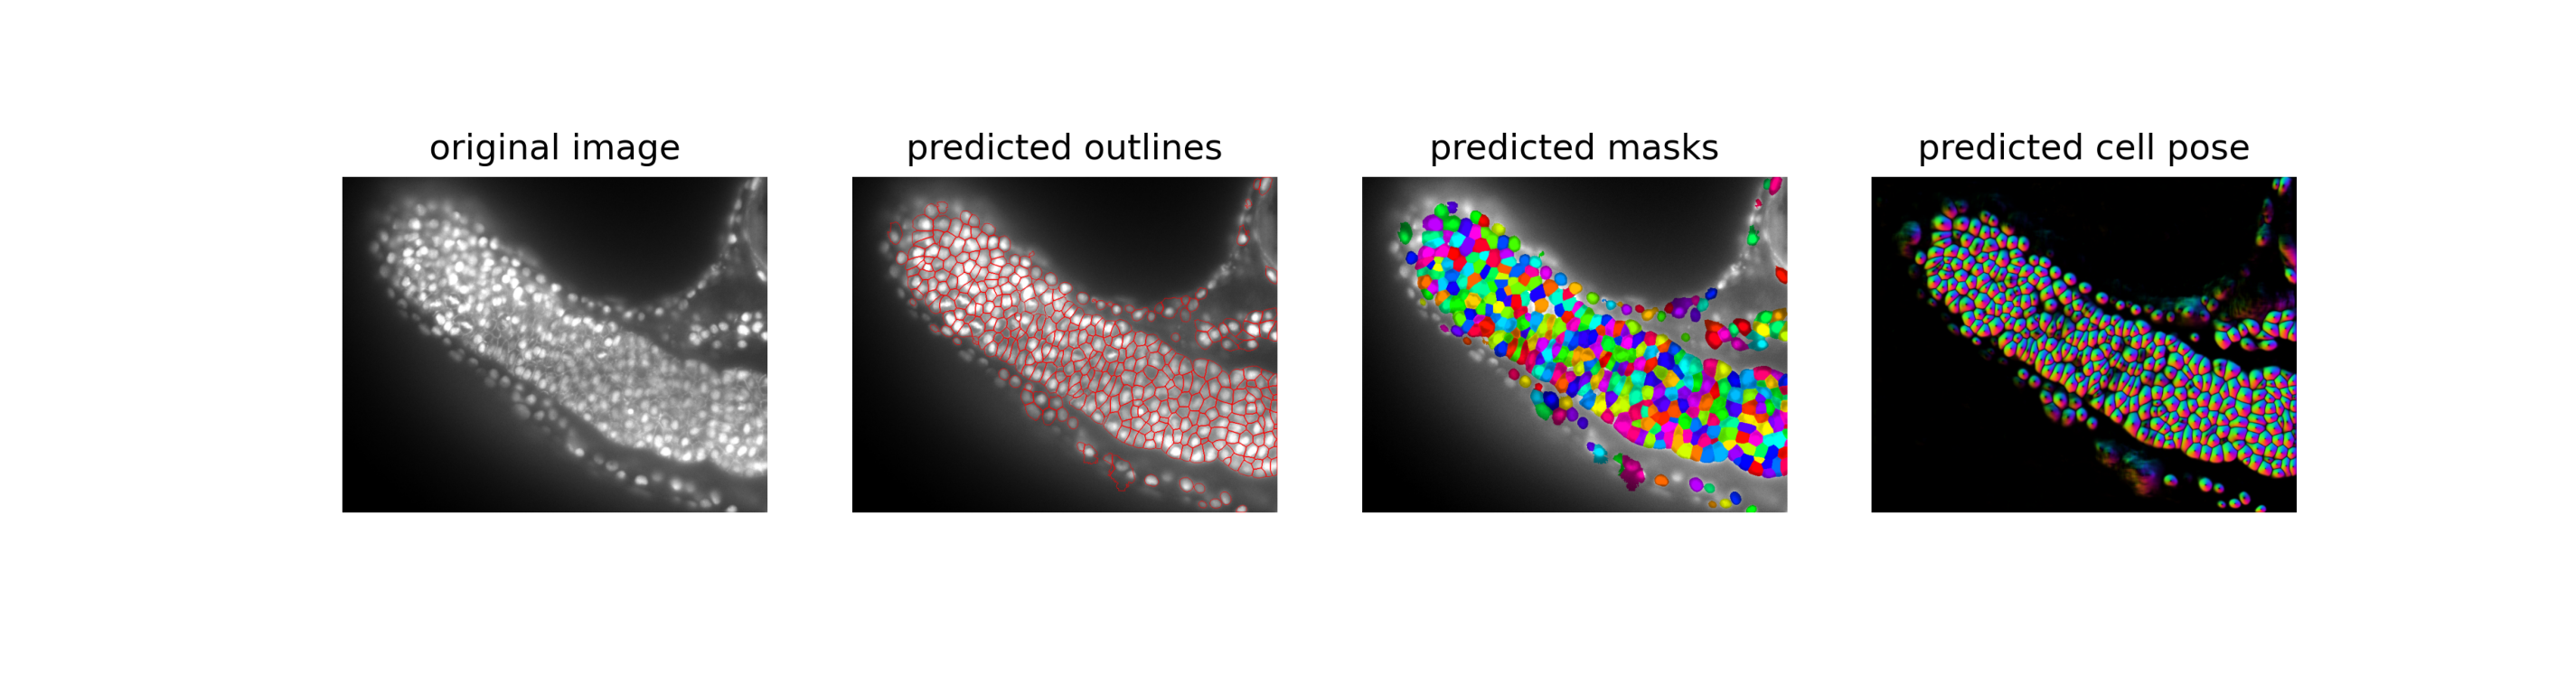

In [12]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output.png'))
plt.axis('off')